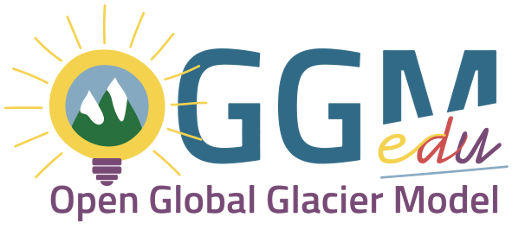

# Glacier advance and retreat

Goals of this notebook:

- understand the concept of the equilibrium line altitude (ELA)
- understand the influence of glacier mass balance on the ELA
- be able to explain glacier advance and retreat in response to a change in the ELA

In [1]:
import oggm

# Constants
from oggm import cfg
cfg.initialize_minimal()
# OGGM flowline model
from oggm.core.flowline import RectangularBedFlowline

# import oggm-edu helper package
import oggm_edu as edu
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Scientific packages
import numpy as np
from IPython.display import Image

# OGGM mass-balance model
from oggm.core.massbalance import LinearMassBalance

# There are several numerical implementations in OGGM core. We use the "FluxBasedModel"
from oggm.core.flowline import FluxBasedModel as FlowlineModel

2021-05-13 15:16:30: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-05-13 15:16:30: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-05-13 15:16:30: oggm.cfg: Multiprocessing: using all available processors (N=8)


In [2]:
# set default font size in plots
plt.rc('font', size=14)

## Model idealised glacier advance and retreat with OGGM

We will first define our idealised glacier, let the glacier grow to an equilibrium state and then model glacier advance and retreat. We represent the different steps as in the [open glacier graphics from the OGGM-EDU website](https://edu.oggm.org/en/latest/glacier_basics.html) (made by Anne Maussion, [Atelier les Gros yeux](http://atelierlesgrosyeux.com/)).

### Initialisation: Let's define our glacier

First, as always, we define a linear bedrock profile:

In [3]:
# define horizontal resolution of the model:
# nx: number of grid points
# map_dx: grid point spacing in meters
nx = 200
map_dx = 200

# define glacier top and bottom altitudes in meters
top = 5000 
bottom = 0

# create a linear bedrock profile from top to bottom
bed_h, surface_h = edu.define_linear_bed(top, bottom, nx)

# calculate the distance from the top to the bottom of the glacier in km
distance_along_glacier = edu.distance_along_glacier(nx, map_dx)

Often glaciers are wider in the accumulation area, so we also construct our idealised glacier such that it is wider above the ELA. 

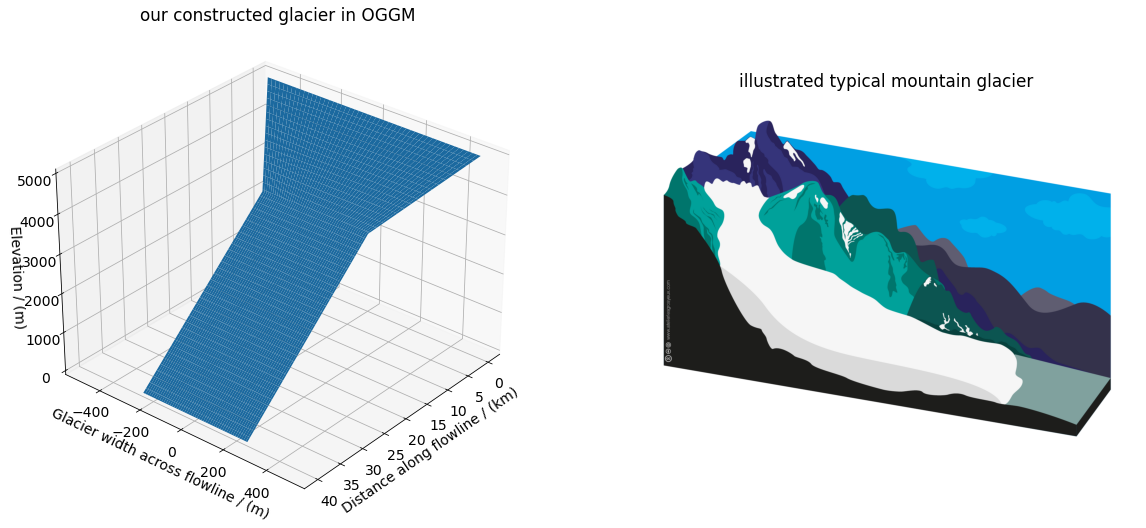

In [4]:
# glacier width at the top of the accumulation area: m
ACCW = 1000

# glacier width at the equilibrium line altitude: m
ELAW = 500

# fraction of vertical grid points occupied by accumulation area
NZ = 1 / 3

# create the widths with a 
widths = edu.define_widths_with_trapezoidal_shape_at_top(topw=ACCW,
                                                     bottomw=ELAW,
                                                     nx=nx,
                                                     nz=NZ,
                                                     map_dx=map_dx)

# plot the idealized glacier 
fig = edu.plot_glacier_3d(distance_along_glacier, bed_h, widths, nx, subplot=True)
plt.title('our constructed glacier in OGGM')
plt.subplot(122)
edu.plot_glacier_graphics(num='01', title='illustrated typical mountain glacier')


**Now we have defined the principle look of our glacier bed (left plot). Before having a glacier as in the right plot, we need to define some other things:** 
- We have to define the shape of our cross-section. OGGM supports three different shapes rectangular, parabolic and trapezoidal. For our experiment we go with the rectangular one:

In [5]:
# describe the widths in "grid points" for the model, based on grid point spacing map_dx
mwidths = np.zeros(nx) + widths / map_dx

# define the glacier flowline
init_flowline = RectangularBedFlowline(surface_h=surface_h,
                                       bed_h=bed_h,
                                       widths=mwidths,
                                       map_dx=map_dx)

- and we need to define the mass balance distribution over the glacier and let the glacier grow to its initial state. We will explain this in the following:

#### **Mass balance and the equilibrium line altitude**

The **mass balance** is the result of several processes that either add mass to the glacier (**accumulation**) or remove mass from the glacier (**ablation**). You can find more details in the [accumulation and ablation notebook](accumulation_and_ablation.ipynb). As a summary the following glacier graphics illustrate this relationship: 

- The left graphic represents a theoretical mass accumulation over the whole glacier depicted by the blue ice volume on top of the grey glacier body.

- In the graphic in the middle a theoretical mass ablation is marked as red ice volume.

- The  graphic on the right shows the resulting mass balance with blue and red arrows in combination with the blue and red volume changes on top of the grey glacier body. In the central part of the glacier where the red line lies directly on the grey glacier body ablation and accumulation canceled each other out.

*The following glacier graphics are taken from the [open glacier graphics](http://edu.oggm.org/en/latest/glacier_basics.html) on OGGM-Edu, made by Anne Maussion, [Atelier les Gros yeux](http://atelierlesgrosyeux.com/)*.

<img src="https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_03.png" width="33%" align="left">
<img src="https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_04.png" width="33%" align="left">
<img src="https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_05.png" width="33%" align="left">

The rates of accumulation and ablation processes, summed over the glacier and over time, determine the *glacier mass balance*: $\dot{m}$, the change in total mass of snow and ice,

$$\dot{m} = \text{accumulation} + \text{ablation}.$$

Since accumulation and ablation generally vary with height, also the glacier mass balance is a function of elevation,

$$\dot{m}(z) = \text{accumulation}(z) + \text{ablation}(z).$$

Mass is continuously redistributed in a glacier: accumulated mass at the top of the glacier is transported downglacier. The driving force of this *ice flow* is gravity. Thus, the mass balance of a region on a glacier depends not only on the mass exchanges induced by accumulation and ablation, but also on the gravity driven transport of ice from the acccumulation area to the ablation area. The *ice flow* is indicated by the grey arrow in this figure:

<img src="https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_06.png" width="60%">

The altitude where $\dot{m}(z) = 0$ is called the *equilibrium line altitude*, short ELA. Hence, the ELA is the altitude where accumulation processes and ablation processes balance each other - in theory. However, in reality the ELA does not exactly exist and can only be approximated.
<img src="https://raw.githubusercontent.com/OGGM/glacier-graphics/master/glacier_intro/png/glacier_07.png" width="60%">

**We want to reproduce these processes above in an experiment using OGGM**.

For this purpose we start with defining a linear mass balance model of the form
$$\dot{m}(z) = (z - ELA) \frac{d\dot{m}}{dz},$$
with the mass balance gradient $\frac{d\dot{m}}{dz}$:

In [6]:
# mass balance gradient with respect to elevation in mm w.e. m^-1 yr^-1
mb_grad = 7

# equilibrium line altitude: height where the glacier width first hits ELAW
ela = bed_h[np.where(widths==ELAW)[0][0]]
print('ELA: {:.2f} m'.format(ela))

# defining the mass balance model
mb_model = LinearMassBalance(ela, grad=mb_grad)

ELA: 3366.83 m


Now that we have all the ingredients to run the model, we just have to initialize it:

In [7]:
# The model requires the initial glacier bed, a mass balance model, and an initial time (the year y0)
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0., min_dt=0, cfl_number=0.01)

### Glacier in Equilibrium

For a glacier to be in equilibrium, we require the specific mass balance (accumulation + ablation) to be zero averaged over a year on the glacier. A glacier is in equilibrium if the glacier will neither retreat nor advance from one year to the next year if the climate stays constant, i.e. if we don't change the ELA. 

Let's run the model until our test glacier is in equilibrium:

In [8]:
model.run_until_equilibrium()

Now, we use a linear accumulation and ablation function from the oggm-edu package for the calculation of the net mass balance (= glacier mass distribution without considering *ice flow*):

In [9]:
# get the equilibrium surface height of our test glacier in equilibrium
initial = model.fls[0].surface_h

# accumulation and ablation balance each other
acc, acc_0 = edu.linear_accumulation(mb_grad, ela, initial, bed_h, mwidths)
abl, abl_0 = edu.linear_ablation(mb_grad, ela, initial, bed_h, mwidths, acc_0)

Now, we use a linear accumulation and ablation function from the oggm-edu package:

``acc_0`` and ``abl_0`` are the accumulation and the ablation at the ELA, respectively - by construction, they should be equal:

In [10]:
print('Mass balance at the ELA: {:.2f} m w.e. yr^-1'.format(float(acc_0 - abl_0)))

Mass balance at the ELA: 0.00 m w.e. yr^-1


Now, we can define the glacier surface after accumulation and ablation, respectively.

In [11]:
# accumulation and ablation surfaces
acc_sfc = initial + acc
abl_sfc = initial + abl

The mass balance is then just the sum of accumulation and ablation:

In [12]:
# net mass balance m w.e yr^-1
mb_we = acc + abl

Near the terminus ablation may totally remove the ice, hence, we need to correct "negative" ice thickness to the glacier bed:

In [13]:
# theoretical glacier surface without ice flow
# corrected to the bed where ice thickness is negative
mb_sfc = edu.correct_to_bed(bed_h, initial + mb_we)

The next figure shows the glacier surface after applying the net mass balance.

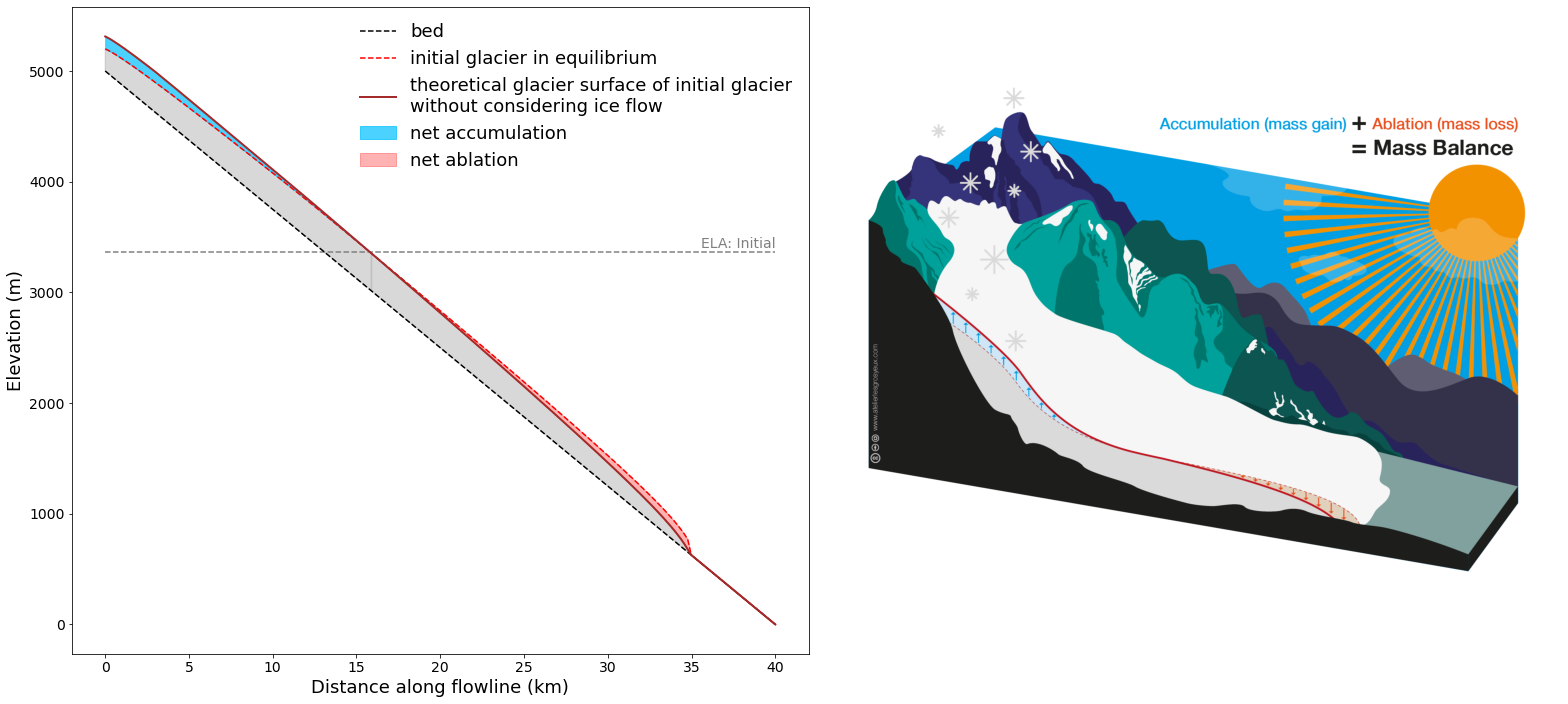

In [14]:
# plot the model glacier
plt.figure(figsize=(22,10))
# fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax = plt.subplot(121)
edu.intro_glacier_plot(ax, distance_along_glacier, bed_h, initial, [mb_sfc],
                       ['theoretical glacier surface of initial glacier\nwithout considering ice flow'], ela=[ela], plot_ela=True,
                       label_init='initial glacier in equilibrium')
ax = plt.subplot(122)
edu.plot_glacier_graphics(num='05')
plt.tight_layout()


Although our initial glacier is in equilibrium, it doesn't mean that the mass-balance is zero everywhere. As visualized above, the net positive mass-balance at the top (more accumulation, less ablation) balances out the net negative mass balance at the tongue (less accumulation, more ablation).

Remember: In the plot above, we visualised the initial glacier in equilibrium (dashed red line) and the theoretical glacier surface after applying the mass balance for a year of accumulation and ablation (solid dark red line). We did not yet include any ice dynamics into the model, so the glacier would not exist in such an imbalanced state with more mass above the equilibrium line and less ice in the ablation zone than in the equilibrium state. This imbalance is compensated by a movement of ice from the top to the bottom, the ice flow. In an undisturbed climate the ice flow together with ablation and accumulation keep the glacier in a steady equilibrium state (dashed red line).

Now we have set the scene to model glacier advance and retreat.

## Advancing Glacier

To simulate a glacier advance, we will use the same glacier as before, but move the ELA downglacier. This is similar to e.g. an abrupt climate cooling over the glacier:

In [19]:
# number of vertical grid points the ELA is shifted downglacier
downglacier = 10

#PATRICK you can change this to your method, if you want or we leave it like that
# run the model until the glacier reaches an equilibrium state 
# with its decreased ELA
advance = edu.linear_mb_equilibrium(bed_h, surface_h, ACCW, ELAW, NZ, mb_grad,
                                    nx, map_dx, idx=downglacier,
                                    advance=True, plot=False)

In [20]:
# decreased ELA
ela_adv = advance.mb_model.get_ela()

In [21]:
print('We move the ELA from initially {:.0f} m downward to {:.0f} m'.format(ela, ela_adv))

We move the ELA from initially 3367 m downward to 3116 m


Now, we can again calculate linear accumulation, ablation and mass balance profiles, but using the decreased ELA:

In [22]:
# accumulation and ablation balance at the decreased ELA
acc_adv, acc_0_adv = edu.linear_accumulation(mb_grad, ela_adv, initial, bed_h, mwidths)
abl_adv, abl_0_adv = edu.linear_ablation(mb_grad, ela_adv, initial, bed_h, mwidths, acc_0_adv)

# net mass balance m w.e yr^-1
mb_adv = acc_adv + abl_adv

# theoretical glacier surface without ice flow
# corrected to the bed where ice thickness is negative
mb_sfc_adv = edu.correct_to_bed(bed_h, initial + mb_adv)

The next figure shows the glacier after applying the net mass balance of the decreased ELA:

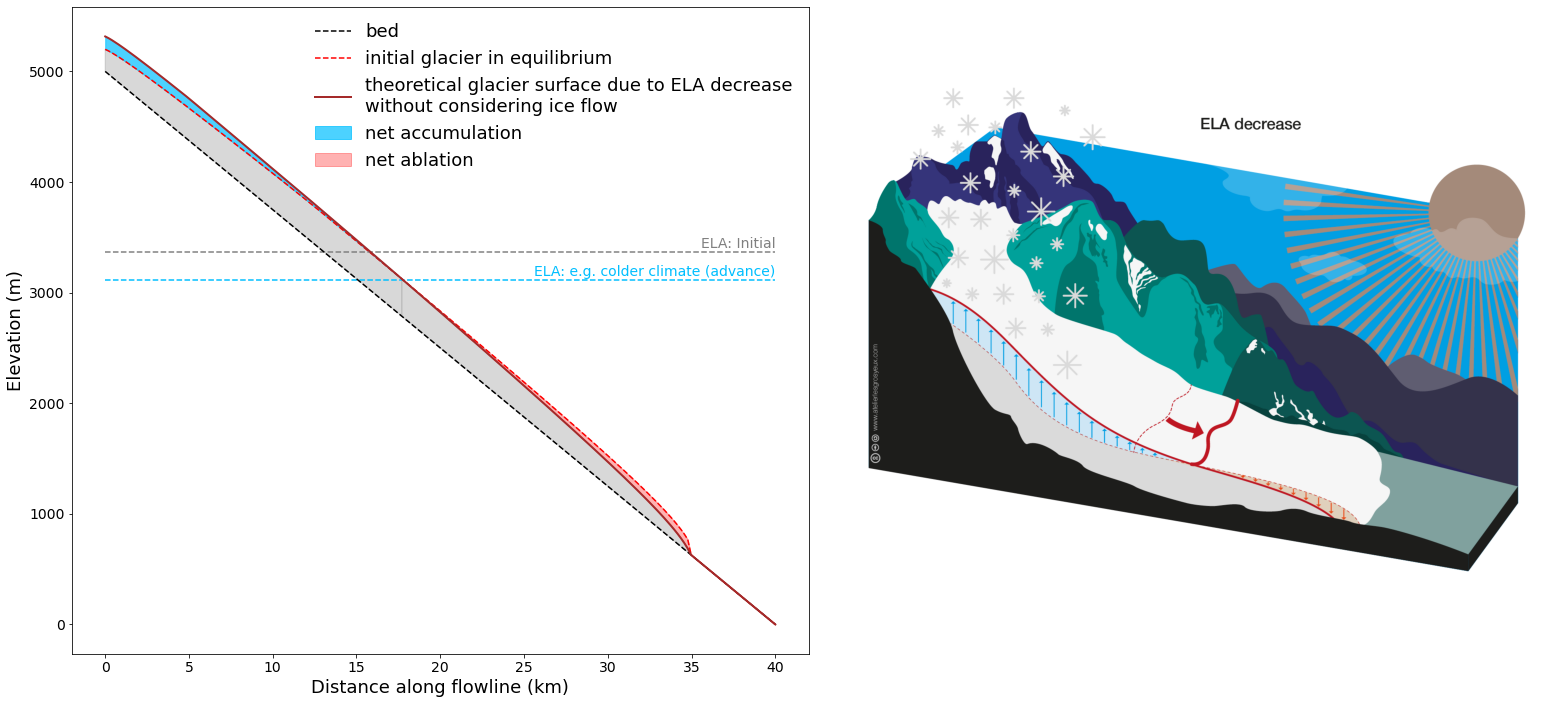

In [23]:
# plot the model glacier
plt.figure(figsize=(22,10))
# fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax = plt.subplot(121)
edu.intro_glacier_plot(ax, distance_along_glacier, bed_h, initial, [mb_sfc_adv],
                       ['theoretical glacier surface due to ELA decrease\nwithout considering ice flow'],
                       ela=[ela, ela_adv], plot_ela=True,
                       label_init='initial glacier in equilibrium',
                      labels_ela = ['e.g. colder climate (advance)'])
ax = plt.subplot(122)
edu.plot_glacier_graphics(num='08')
plt.tight_layout()


More accumulation and/or less ablation leads to a **decrease** of the ELA and therefore to an increase of the accumulation area and a decrease of the ablation area, as shown in the modelled glacier and the illustration. Note, that our constructed glacier is wider in the accumulation area. Therefore, the accumulation area has increased even if this is not so visible from the cross-section.

The increase in the accumulation area leads to a net mass gain compared to the former glacier extent. As discussed in the [accumulation and ablation notebook](accumulation_and_ablation.ipynb), mass is transported downglacier by a gravity driven ice flow obeying conservation of mass

$$\frac{\partial H}{\partial t} = \dot{m} - \nabla \cdot \vec{q}.$$

When our glacier with a lower ELA is again in equilibrium, the resulting net mass gain due to the ELA decrease leads to a glacier advance:

In [24]:
# the glacier surface in equilibrium with the decreased ELA
advance_s = advance.fls[-1].surface_h

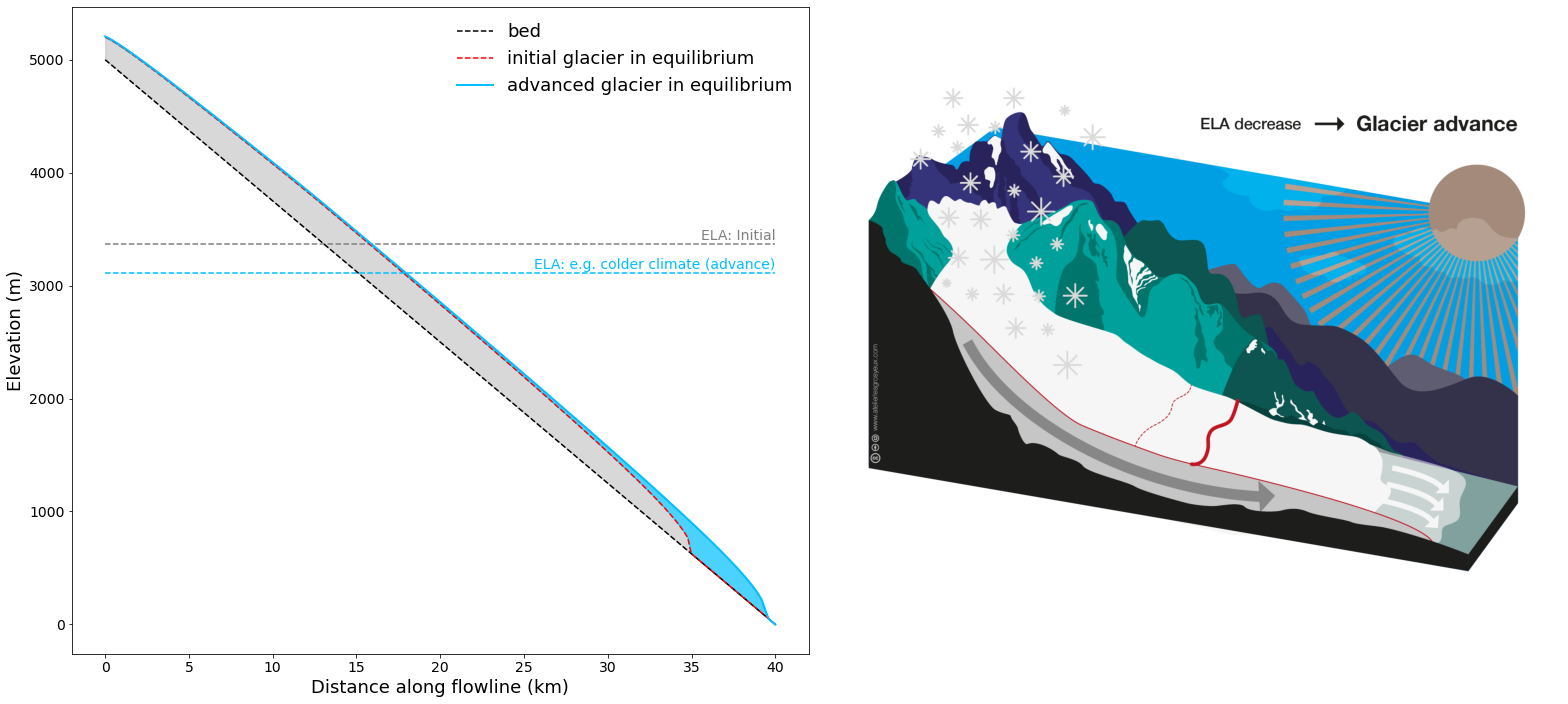

In [25]:
# plot the model glacier
plt.figure(figsize=(22,10))
# fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax = plt.subplot(121)
edu.intro_glacier_plot(ax, distance_along_glacier, bed_h, initial, [advance_s],
                       ['advanced glacier in equilibrium'],
                       ela=[ela, ela_adv], plot_ela=True,
                       label_init='initial glacier in equilibrium',
                      labels_ela = ['e.g. colder climate (advance)'])
ax = plt.subplot(122)
edu.plot_glacier_graphics(num='09')
plt.tight_layout()


This downslope glacier advance is the result of an increased ice flow $\vec{q}$, as indicated by the thick arrow in the illustration on the right. 

## Retreating glacier

To simulate a glacier retreat, we will again use the same glacier, but this time move the ELA upglacier. This is similar to e.g. an abrupt climate warming over the glacier:

In [43]:
# number of vertical grid points the ELA is shifted upglacier
# if you want to see the differences better you can increase here the value to e.g. 30
upglacier = 10

# run the model until the glacier reaches an equilibrium state with its decreased ELA
retreat = edu.linear_mb_equilibrium(bed_h, surface_h, ACCW, ELAW, NZ, mb_grad,
                                    nx, map_dx, idx=upglacier, retreat=True, plot=False)
# decreased ELA
ela_rtr = retreat.mb_model.get_ela()

In [44]:
print('We move the ELA from initially {:.0f} m upward to {:.0f} m'.format(ela, ela_rtr))

We move the ELA from initially 3367 m upward to 3593 m


Now, we can again calculate linear accumulation, ablation and mass balance profiles, but using the increased ELA:

In [45]:
# accumulation and ablation balance at the decreased ELA
acc_rtr, acc_0_rtr = edu.linear_accumulation(mb_grad, ela_rtr, initial, bed_h, mwidths)
abl_rtr, abl_0_rtr = edu.linear_ablation(mb_grad, ela_rtr, initial, bed_h,
                                         mwidths, acc_0_rtr)
# net mass balance m w.e yr^-1
mb_rtr = acc_rtr + abl_rtr

# theoretical glacier surface without ice flow
# corrected to the bed where ice thickness is negative
mb_sfc_rtr = edu.correct_to_bed(bed_h, initial + mb_rtr)

The next figure shows the glacier after applying the net mass balance using the increased ELA:

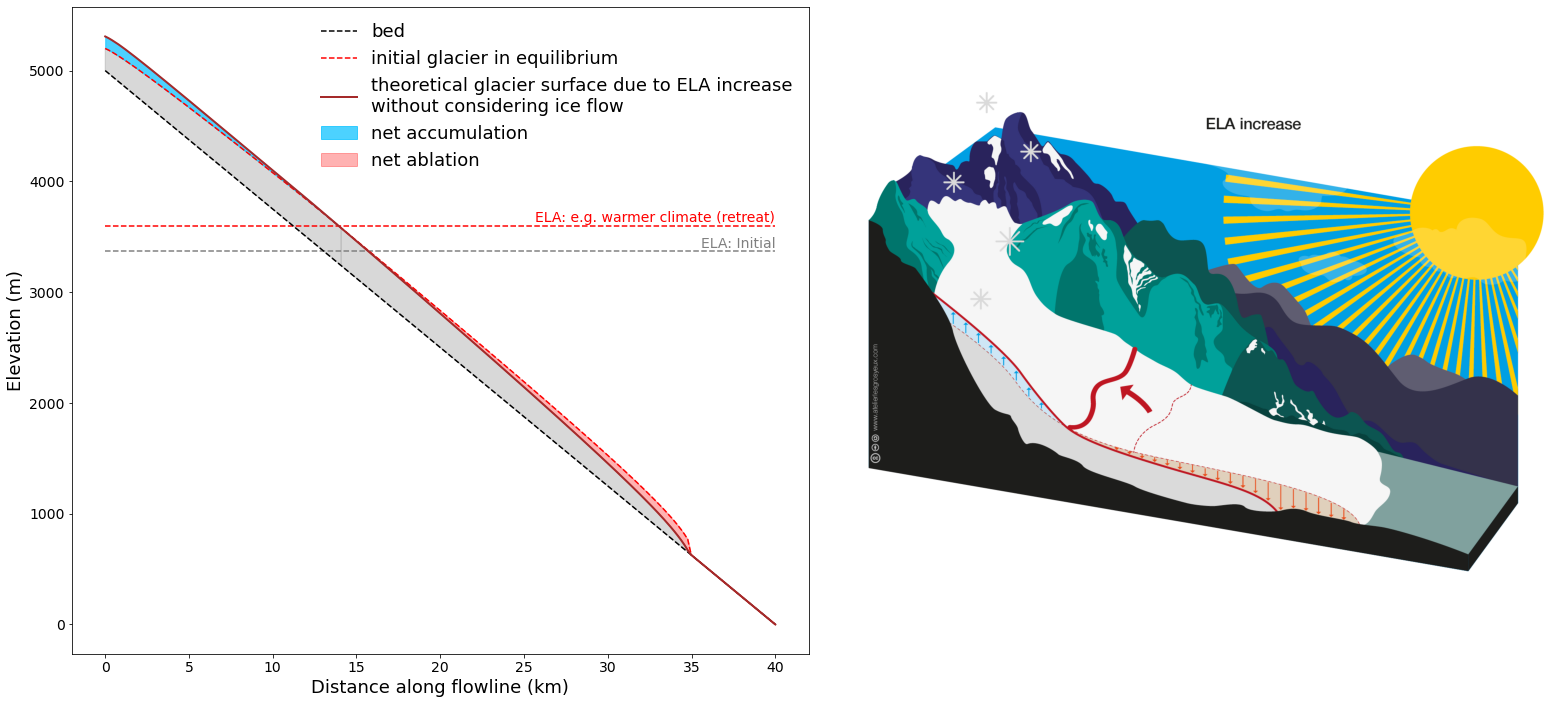

In [46]:
# plot the model glacier
plt.figure(figsize=(22,10))
ax = plt.subplot(121)
edu.intro_glacier_plot(ax, distance_along_glacier, bed_h, initial, [mb_sfc_rtr],
                       ['theoretical glacier surface due to ELA increase\nwithout considering ice flow'],
                       ela=[ela, ela_rtr], plot_ela=True,
                       label_init='initial glacier in equilibrium',
                      labels_ela = ['e.g. warmer climate (retreat)'])

ax = plt.subplot(122)
edu.plot_glacier_graphics(num='10')
plt.tight_layout()


Analogously, less accumulation and/or more ablation leads to an increase in the ELA and thus to an increase of the ablation area.

The increase in the ablation area leads to a net mass loss compared to the former glacier extent. When our glacier with a higher ELA is in equilibrium, the glacier retreats: 

In [47]:
# the glacier surface in equilibrium with the decreased ELA
retreat_s = retreat.fls[-1].surface_h

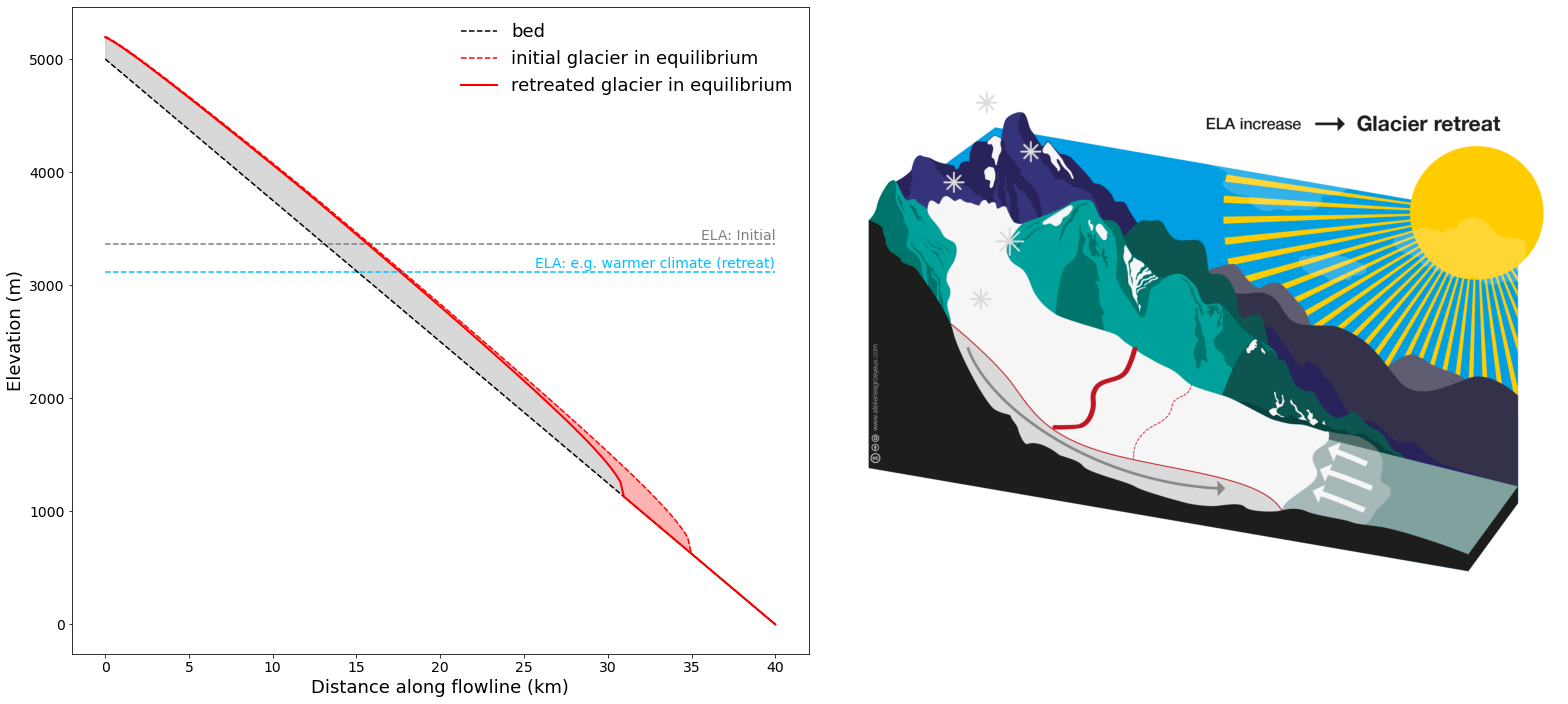

In [48]:
# plot the model glacier
plt.figure(figsize=(22,10))
# fig, ax = plt.subplots(1, 1, figsize=(16, 9))
ax = plt.subplot(121)
edu.intro_glacier_plot(ax, distance_along_glacier, bed_h, initial, [retreat_s],
                       ['retreated glacier in equilibrium'],
                       ela=[ela, ela_adv], plot_ela=True,
                       label_init='initial glacier in equilibrium',
                      labels_ela = ['e.g. warmer climate (retreat)'])
ax = plt.subplot(122)
edu.plot_glacier_graphics(num='11')
plt.tight_layout()


This upslope glacier retreat is a result of a decreased ice flow $\vec{q}$, as indicated by the thin arrow in the right illustration above. 

## Take home points

- The equilibrium line altitude (ELA) is the altitude on a glacier where accumulation and ablation balance, meaning $\dot{m}(z) = 0$ at $z=$ ELA
- A decrease in the ELA leads to:
    1. an increase in the accumulation
    2. a decrease in the ablation area
    3. a net mass gain resulting in an increased ice flux downglacier
    4. a glacier advance
- An increase in the ELA leads to:
    1. a decrease in the accumulation area
    2. an increase in the ablation area
    3. a net mass loss resulting in a decreased ice flux downglacier
    4. a glacier retreat

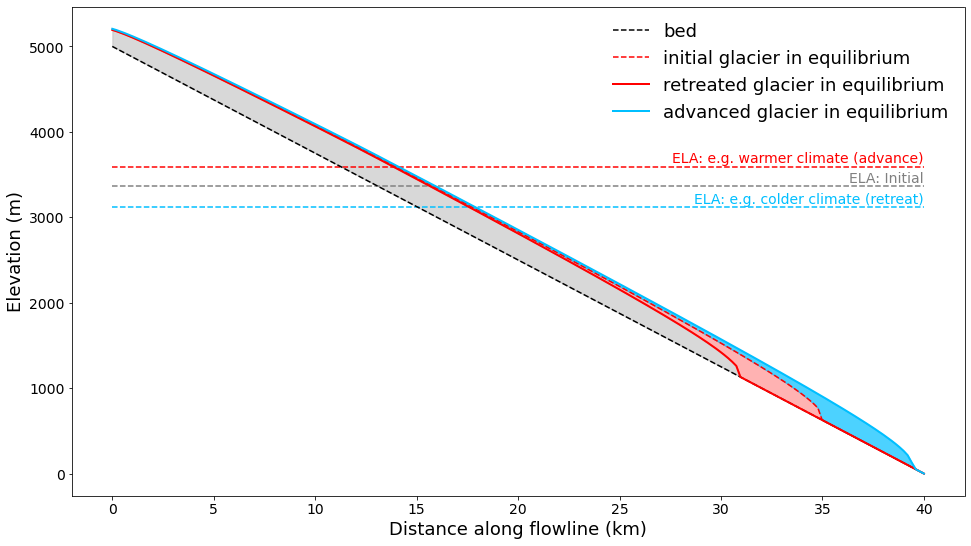

In [49]:
# or if you are a visual type learner
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
edu.intro_glacier_plot(ax, distance_along_glacier, bed_h, initial,
                       [retreat_s, advance_s,], ['retreated glacier in equilibrium',
                                                 'advanced glacier in equilibrium',],
                       label_init='initial glacier in equilibrium',
                       labels_ela = ['e.g. colder climate (retreat)',
                                    'e.g. warmer climate (advance)'],
                       ela=[ela, ela_adv, ela_rtr], plot_ela=True)

## What's next?

[Back to table of contents](welcome.ipynb) or [notebook: real glacier simulations](real_glacier_simulations.ipynb)